# Predicting No-Shows for Medical Appointments

This notebook goes through some concepts and modeling steps for binary classification. The data is downloaded from kaggle, from Medical Appointment No Show case.

https://www.kaggle.com/joniarroba/noshowappointments


Contents:
 1. Explain the goal
 2. Introduce the data
 3. Choose performance metric
 4. Pre-process the data
 5. Feature engineering
 6. Algorithm evaluation (logistic, random forest, xgboost)
 7. Conclusion and deploying model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import data_utils as du

In [2]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Goal - Predicting No-Shows for Medical Appointments


The goal of this notebook is to see how well we can predict if a patient will show up for their upcoming medical appointment. For this we will be using a data set of 110.527 medical appointments with 14 associated variables.

# Data

## Introduction

We have the following information, on appointment level:
1. PatientId: Identification of a patient
2. AppointmentID: Identification of each appointment
3. Gender: Male or Female
4. AppointmentDay:  The day of the actual appointment, when they have to visit the doctor.
5. ScheduledDay: The day someone called or registered the appointment.
6. Age: How old is the patient.
7. Neighbourhood: Where the appointment takes place.
8. Scholarship: True of False. Brazilian social welfare program: https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia
9. Hipertension: True or False
10. Diabetes: True or False
11. Alcoholism: True or False
12. Handicap: True or False
13. SMS_received: 1 or more messages sent to the patient.
14. **No-show**: True or False. Out target variable, tells us if the patient showed-up or not to the appointment

## Loading the Data

In [3]:
df = pd.read_csv('./data/no-shows-data.csv', dtype={'PatientId':str})
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


## Explore dataset

In [4]:
df.describe()

,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received
count,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


## Target variable and class imbalance discussion

Now let's analyze the target variable distribution

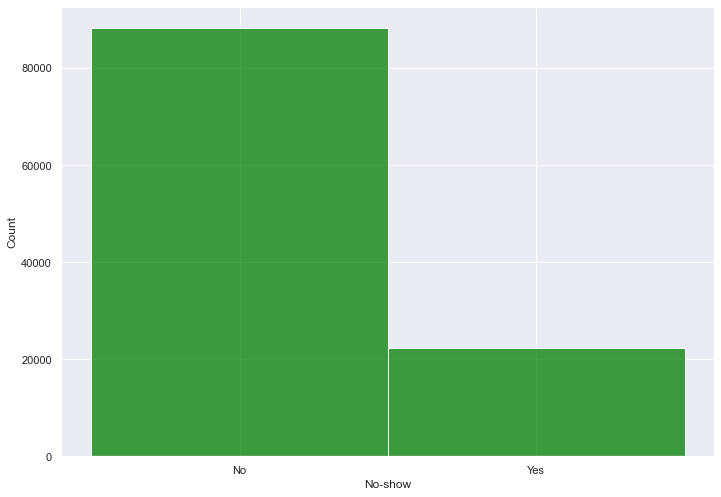

In [5]:
sns.histplot(df['No-show'], color='green');

We can see that there are about 4 times more "No"-s than "Yes"-es. We can deal with this imbalance in a few ways:
1. Choose the performance metric for the models in a careful way
2. Add a larger penalty for the minority class in the loss function
3. Random oversample - sample minority class observations from the data set until we have about same number of points for each class
4. Synthetic oversample (SMOTE) - oversample minority class observations and generate features using k-nn

# Performance metric

Related to point 1., if we only look at accuracy we can be misled. Accuracy is defined as:

\begin{equation*}
Accuracy = \frac{TP + TN}{P+N}
\end{equation*}

So let's assume if there is only 1 positive example and 100 observations. If our model predicts only negatives (100 negatives) then the $TP$ will be 0, the $TN$ will be 99. So the accuracy will be 99%., which is misleading.

In such cases we could use other performance metrics. One is precision, which is defined as the proportion of correctly predicted positives out of all positive predictions:

\begin{equation*}
Precision = \frac{TP}{TP+FP}
\end{equation*}

Another measure is the recall, which is the ratio of correctly predicted positives, out of all positives:

\begin{equation*}
Recall = \frac{TP}{P} = \frac{TP}{TP+FN}
\end{equation*}

In the numerical example above, because $TP$ is zero, both precision and recall will be zero.

If we want only one metric we can use the F1 score which is the harmonic mean of precision and recall:

\begin{equation*}
F_1 = 2\frac{Precision \cdot Recall}{Precision + Recall}
\end{equation*}

# Pre-processing the data

The plan is to:
* Convert target to binary variable
* Convert gender to binary variable
* Convert dates to timestamp

In [6]:
df_pre = du.pre_process(df)

In [7]:
df_pre.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,29872499824296,5642903,1,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,558997776694438,5642503,0,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4262962299951,5642549,1,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,867951213174,5642828,1,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8841186448183,5642494,1,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0


# Feature Engineering

Can one patient have multiple appointments?

In [8]:
app_per_pat = df.groupby('PatientId').count()['AppointmentID'].reset_index()
app_per_pat.columns = ['PatientId', 'Appointment_count']

Let's see the distribution of patients by the number of appointments

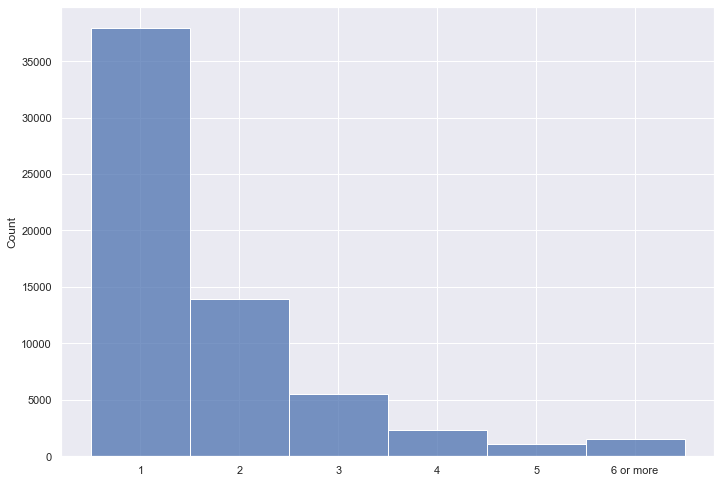

In [9]:
sns.histplot(np.where(app_per_pat['Appointment_count'].sort_values()>=6,
                                 '6 or more',
                                 app_per_pat['Appointment_count'].sort_values().astype(str)));

Almost half of the patients have more than one appointment. We should consider to somehow include the history of previous visits as an explanatory variable.

After some testing I added the following features:
* Number of days between scheduled day and appointment day **DaysToApp**
* If scheduled appointment is in weekend or not **AppWeekend**
* Number of previous appointments at time of appointment **PrevAppoint**
* Ratio of previously missed appointments at time of appointment **NoShowRatio**

The last two features might be noisy for appointments on the same day because we miss the hour and minute information.

In [10]:
features = du.feature_engineering(df_pre)

In [11]:
features.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,DaysToApp,AppWeekend,PrevAppoint,PrevNoShowAppoint,NoShowRatio
0,29872499824296,5642903,1,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,0,0,0.0,0.0
1,558997776694438,5642503,0,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0,0,1,0.0,0.0
2,4262962299951,5642549,1,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0,0,0,0,0.0,0.0
3,867951213174,5642828,1,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0,0,0,0.0,0.0
4,8841186448183,5642494,1,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0,0,0,0.0,0.0


## Splitting the Data
We need to split the data into test and train sets. If you are going for extensive optimisation, you will need a more elaborate evaluation strategy.

In [12]:
features.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'No-show',
       'DaysToApp', 'AppWeekend', 'PrevAppoint', 'PrevNoShowAppoint',
       'NoShowRatio'],
      dtype='object')

In [13]:
# explanatory variables
x_cols = ['Gender', 'Age', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received',
       'DaysToApp', 'AppWeekend', 'PrevAppoint', 'NoShowRatio']

In [14]:
X_train, X_test, Y_train, Y_test = du.splitting_data(features, x_cols, test_size=0.2)

In [15]:
print ("Train size %d \nTest size %d "% (X_train.shape[0], X_test.shape[0]))

Train size 88421 
Test size 22106 


# Model Evaluation

We will compare 3 models:
* Logistic regression
* Random forest classifier
* XGBoost classifier

First i will detail the logistic regression model

In [16]:
df_mod_train = pd.DataFrame(Y_train.copy().rename("NoShow"))

In [17]:
df_mod_train = pd.concat([df_mod_train, X_train], axis=1)

## Baseline model - logistic regression

Let's assume a linear relationship between our explanatory variables and a quantity $z$:

\begin{equation*}
z = \beta_0 + \beta_1*Gender + \beta_2*Age + \cdots + \beta_{11}*PrevAppoint + \beta_{12}*NoShowRatio
\end{equation*}

To model the probability of no-show we plug in $z$ to a function called $sigmoid$ or $logistic$, that maps a real value to the interval (0, 1). Here $p$ is the probability that an observation belongs to the positive class:

\begin{equation*}
P(y=1) = p = \frac{1}{(1 + e^{-z})} = \frac{e^{z}}{(1 + e^{z})}
\end{equation*}

Shape of $sigmoid$ function

<img src="logistic-curve.png" style="width: 300px">

Conversely we can express $z$ in terms of $p$. The quantity $z$ is also called log-odds.

\begin{equation*}
z = \log \left( \frac{p}{1-p} \right) = - \log \left( \frac{1}{p}-1 \right)
\end{equation*}

I will be using the statsmodel library in this case, to see the estimation summary

In [18]:
import statsmodels.formula.api as smf

In [19]:
ols = smf.logit("""NoShow ~ Gender + Age + Scholarship + Hipertension +
       Diabetes + Alcoholism + Handicap + SMS_received +
       DaysToApp + AppWeekend + PrevAppoint + NoShowRatio""",
                     data=df_mod_train)
olsf = ols.fit()
# Print out the statistics
olsf.summary()

Optimization terminated successfully.
         Current function value: 0.477799
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 NoShow   No. Observations:                88421
Model:                          Logit   Df Residuals:                    88408
Method:                           MLE   Df Model:                           12
Date:                Sat, 07 Nov 2020   Pseudo R-squ.:                 0.05023
Time:                        15:25:25   Log-Likelihood:                -42248.
converged:                       True   LL-Null:                       -44482.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.6058      0.021    -76.015      0.000      -1.647      -1.564
Gender          -0.0036      0.019     -0.194      0.846      -0.040       0.033
Age             -0.0075      0.000    -16.723      0.000      -0.008      -0.007
Scholarship      0.2023      0.028      7.254      0.000       0.148       0.257
Hipertension    -0.0492      0.028     -1.746      0.081      -0.105       0.006
Diabetes         0.1190      0.039      3.049      0.002       0.043       0.196
Alcoholism       0.1948      0.052      3.758      0.000       0.093       0.296
Handicap         0.0557      0.055      1.009      0.313      -0.052       0.164
SMS_received     0.3864      0.019     20.453      0.000       0.349       0.423
DaysToApp        0.0222      0.001     40.304      0.000       0.021       0.023
AppWeekend       0.2614      0.461      0.567      0.571      -0.643       1.166
PrevAppoint     -0.0132      0.003     -4.464      0.000      -0.019      -0.007
NoShowRatio      1.0088      0.030     33.416      0.000       0.950       1.068
================================================================================
"""

How do these coefficients affect the probability of no-show?

The intercept is the log-odds of an appointment being a no-show when all other factors are zero.

In the example above we see that age has a coefficient of -0.0075. What does that mean?
Let's see what happens with the probability of no-show if the age of the patient increases by 1 year.

\begin{equation*}
z_i = \beta_0 + \beta_1*Gender_i + \beta_2*Age_i + ... 
\end{equation*}

\begin{equation*}
z_i' = \beta_0 + \beta_1*Gender_i + \beta_2*(Age_i+1) + ... 
\end{equation*}

So the log-odds difference is equal to the coefficient:

\begin{equation*}
z_i' - z_i = \beta_2
\end{equation*}

We can take the exponent:

\begin{equation*}
e^{(z_i' - z_i)} = e^{\beta_2}
\end{equation*}

\begin{equation*}
\frac{e^{z_i'}}{e^{z_i}}  = e^{\beta_2}
\end{equation*}

That means the exponential of the coefficient also expresses the odds ratio:

\begin{equation*}
\frac{ \left( \frac{p'}{1-p'} \right) }{\left( \frac{p}{1-p} \right) }= e^{\beta_2}
\end{equation*}

In [20]:
print("Odd ratio: %.4f%%"% ((np.exp(-0.0075))*100))

Odd ratio: 99.2528%


For one year increase in age we can expect a 0.75% drop in odds of now-show

The P-value tells what are the chances of getting a test statistic at least as extreme as the one we got, in a sample of the size we have. In the regression report the test statistic represents the null hypothesis that the coefficient of the model (of the population) is equal to zero. A low value of the P-value means that it is very unlikely to observe our sample given that the null is correct.

So in logistic regression we can easily interpret the coefficients and their statistical significance.

## About the random forest model

To understand random forests we need to first understand decision trees.

* A decision tree model tries to explain the target variable using the explanatory variables, in a manner similar to a decision tree used to illustrate any other process (with yes/no branches).

* So we build a decision tree from the explanatory variables, in the order that they can separate "no-show" and "show" appointments.

* In practice decision trees are not able to generalize and they are not so good estimators (they fit the training data too closely)

A random forest is combines a set of "weak" estimators like the decision trees into a ensemble estimator that aggregates the output of the weak estimators. 

* Random sample observations with replacement to construct a slightly different data set
* Select a random subset of explanatory variables and only use those to build a decision tree
* Iterate the steps above $N$ times to build different decision trees. In the end make a prediction by aggregating the votes of the $N$ trees.


The way explanatory variables interact with our target in a random forest is not as easy to interpret compared to the logistic regression.

## Model evaluation with cross validation

We will score the 3 models on 4 subsets of the training data. Then we will fine tune the selected model using grid search.

<img src="grid_search_cross_validation2.png" style="width: 600px">

First we scale the data

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

X_train_sc.loc[:, :] = sc.fit_transform(X_train)
X_test_sc.loc[:, :] = sc.transform(X_test)

We will compare 3 models, using one metric, the F1 score: 
* Logistic regression
* Random forest classifier
* XGBoost classifier

In [22]:
#import and initiate the 3 candidate models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

log_reg = LogisticRegression()
rfo_clf = RandomForestClassifier()
xgb_clf = XGBClassifier()

#save models in a list to loop over later
models = [log_reg, rfo_clf, xgb_clf]

In [23]:
from sklearn.model_selection import cross_val_score

model_perf = {}

for m in models:
    scores = cross_val_score(m, X_train_sc, Y_train, scoring="f1", cv=4)
    avg_score = scores.mean()
    model_perf[type(m).__name__] = avg_score

In [24]:
model_perf

{'LogisticRegression': 0.05763960871776469,
 'RandomForestClassifier': 0.27276494294314746,
 'XGBClassifier': 0.13902139359527205}

## Hyperparameter tuning with grid search

Next we find better parameter for the random forest model using grid search

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = [
{'n_estimators': [10, 100, 500], 'max_features': [2, 8, 'auto'], 'max_depth': [4, None]},
]

# add class weights
rfo_clf_gr = RandomForestClassifier(class_weight='balanced')

grid_search = GridSearchCV(rfo_clf_gr, param_grid, cv=4, scoring='f1',
                           return_train_score=True,  n_jobs=-1, verbose=1)

grid_search.fit(X_train_sc, Y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.4min finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'max_depth': [4, None],
                          'max_features': [2, 8, 'auto'],
                          'n_estimators': [10, 100, 500]}],
             return_train_score=True, scoring='f1', verbose=1)

In [26]:
grid_search.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=8,
                       n_estimators=500)

In [27]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.43536235064380613 {'max_depth': 4, 'max_features': 2, 'n_estimators': 10}
0.4375082661732575 {'max_depth': 4, 'max_features': 2, 'n_estimators': 100}
0.43784201838435644 {'max_depth': 4, 'max_features': 2, 'n_estimators': 500}
0.4415859519574306 {'max_depth': 4, 'max_features': 8, 'n_estimators': 10}
0.4426225493403385 {'max_depth': 4, 'max_features': 8, 'n_estimators': 100}
0.4430131619123841 {'max_depth': 4, 'max_features': 8, 'n_estimators': 500}
0.43928246320789777 {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 10}
0.43844410826371427 {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}
0.4390318788669143 {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
0.2926740199936143 {'max_depth': None, 'max_features': 2, 'n_estimators': 10}
0.30268778718024725 {'max_depth': None, 'max_features': 2, 'n_estimators': 100}
0.3043782574777741 {'max_depth': None, 'max_features': 2, 'n_estimators': 500}
0.2895848927930701 {'max_depth': None, 'max_features': 8, 'n_es

In [28]:
rfo_best = grid_search.best_estimator_

# Conclusion and Deployment

Let's see how the model performs on the test data set:

In [29]:
Y_pred_test = rfo_best.predict(X_test_sc)

In [30]:
from sklearn.metrics import f1_score

In [31]:
print("The F1 score on the test data is %.2f "%  f1_score(Y_test, Y_pred_test))

The F1 score on the test data is 0.45 


This means that our model generalizes well and is not overfitting the training data.

Let's look at what variables explain best the separation between show and no-show

Gender, Score: 0.00107
Age, Score: 0.07856
Scholarship, Score: 0.00025
Hipertension, Score: 0.00131
Diabetes, Score: 0.00007
Alcoholism, Score: 0.00017
Handicap, Score: 0.00015
SMS_received, Score: 0.04139
DaysToApp, Score: 0.77737
AppWeekend, Score: 0.00000
PrevAppoint, Score: 0.01274
NoShowRatio, Score: 0.08694


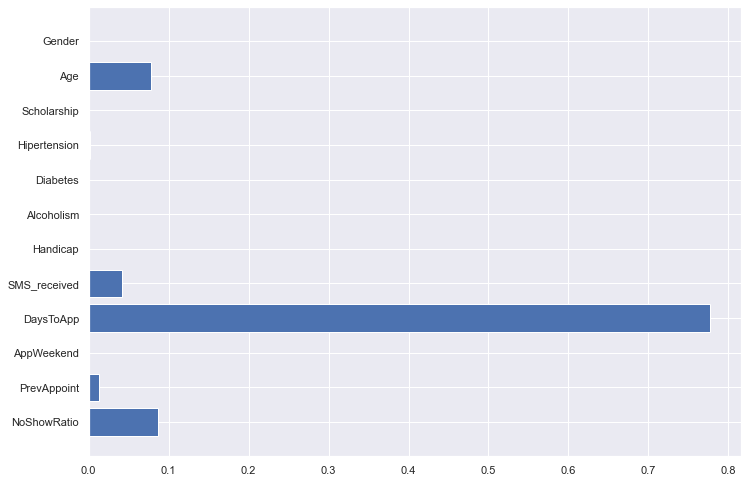

In [32]:
importance = rfo_best.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('%s, Score: %.5f' % (X_train.columns[i],v))
# plot feature importance
plt.barh([x for x in list(X_train.columns)[::-1] ], importance[::-1]  )
plt.show()

Both the logistic regression and random forest models suggest that age, the number of days before the an appointment is scheduled and when it should take place, the history on no-shows and if one or more SMS's have been sent correlate with the probability of no-show.

We can pickle the model for later deployment:

In [33]:
from joblib import dump
dump(rfo_best, 'no-show-rfo-clf.joblib') 

['no-show-rfo-clf.joblib']

Also we need the scaler:

In [34]:
dump(sc, 'no-show-scaler.joblib') 

['no-show-scaler.joblib']

Example of a prediction:

In [35]:
age = 60
sms = 1
days = 180
ptotap = 10
ratio = 0.9

In [36]:
X_new = pd.DataFrame(data = [[1, age, 0, 0, 0, 0, 0, sms, days, 0, ptotap, ratio]], columns = ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handicap', 'SMS_received', 'DaysToApp', 'AppWeekend',
       'PrevAppoint', 'NoShowRatio'])
X_new_sc = sc.transform(X_new)

In [37]:
rfo_best.predict_proba(X_new_sc)[0][1]

0.7325462461636942

I used the pickled model in a web app calculator container. The code for the web app is in this same repository.